In [1]:
from sec_certs.dataset.fips_mip import MIPDataset
from sec_certs.dataset.fips_iut import IUTDataset
from sec_certs.sample.fips_mip import MIPStatus
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
import tqdm
import matplotlib.ticker as mtick
import warnings
from pathlib import Path

plt.style.use("seaborn-whitegrid")
sns.set_palette("deep")
sns.set_context("notebook") # Set to "paper" for use in paper :)

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

## IUT dataset

In [2]:
iut_dset = IUTDataset.from_web_latest()http://localhost:8888/notebooks/notebooks/fips/in_process.ipynb#

In [3]:
iut_global_df = pd.DataFrame(iut_dset.snapshots, columns=["timestamp", "displayed", "not_displayed", "total"])
iut_global_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727 entries, 0 to 726
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      727 non-null    datetime64[ns]
 1   displayed      721 non-null    float64       
 2   not_displayed  721 non-null    float64       
 3   total          721 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 22.8 KB


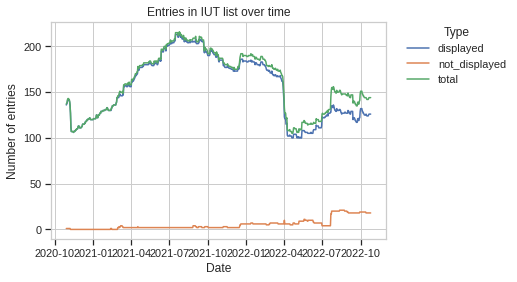

In [4]:
iut_melt = iut_global_df.melt("timestamp", var_name="type", value_name="count")
line = sns.lineplot(data=iut_melt, x="timestamp", y="count", hue="type")
line.set(xlabel="Date", ylabel="Number of entries", title="Entries in IUT list over time")
line.legend(title="Type", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [5]:
s0 = iut_dset.snapshots[0]
print(s0.__dict__.keys())
print(next(iter(s0.entries)))

dict_keys(['entries', 'timestamp', 'last_updated', 'displayed', 'not_displayed', 'total'])
IUTEntry(module_name='F5(R) vCMP Cryptographic Module', vendor_name='F5, Inc.', standard='FIPS 140-3', iut_date=datetime.date(2021, 12, 14))


In [6]:
def iut_key(entry):
    return entry.module_name, entry.vendor_name, entry.standard

iut_first_seen = {}
iut_last_seen = {}
for snapshot in sorted(iut_dset.snapshots, key=lambda x: x.timestamp):
    snapshot_date = snapshot.timestamp.date()
    for entry in snapshot.entries:
        entry_key = entry #iut_key(entry) # or entry here
        if entry_key not in iut_first_seen:
            iut_first_seen[entry_key] = snapshot_date
        if entry_key not in iut_last_seen or iut_last_seen[entry_key] < snapshot_date:
            iut_last_seen[entry_key] = snapshot_date

#iut_local_df = pd.DataFrame([(entry[0], entry[1], entry[2], iut_first_seen[entry], iut_last_seen[entry], iut_last_seen[entry] == snapshot_date) for entry in iut_first_seen.keys()], columns=("name", "vendor", "standard", "first_seen", "last_seen", "present"))
iut_local_df = pd.DataFrame([(entry.module_name, entry.vendor_name, entry.standard, entry.iut_date, iut_first_seen[entry], iut_last_seen[entry], iut_last_seen[entry] == snapshot_date) for entry in iut_first_seen.keys()], columns=("name", "vendor", "standard", "iut_date", "first_seen", "last_seen", "present"))
iut_local_df = iut_local_df.astype({"standard": "category", "iut_date": "datetime64", "first_seen": "datetime64", "last_seen": "datetime64", "present": "bool"}).fillna(value=np.nan)
iut_local_df["seen_for_iut"] = (iut_local_df.last_seen - iut_local_df.iut_date).dt.days
iut_local_df["seen_for"] = (iut_local_df.last_seen - iut_local_df.first_seen).dt.days

print("All:")
print("Average seen for", np.mean(iut_local_df.seen_for))
print("Average seen for (FIPS 140-2)", np.mean(iut_local_df.loc[iut_local_df.standard == "FIPS 140-2"].seen_for))
print("Average seen for (FIPS 140-3)", np.mean(iut_local_df.loc[iut_local_df.standard == "FIPS 140-3"].seen_for))
print("Average seen for[iut]", np.mean(iut_local_df.seen_for_iut))
print("Average seen for[iut] (FIPS 140-2)", np.mean(iut_local_df.loc[iut_local_df.standard == "FIPS 140-2"].seen_for_iut))
print("Average seen for[iut] (FIPS 140-3)", np.mean(iut_local_df.loc[iut_local_df.standard == "FIPS 140-3"].seen_for_iut))

print("Only not present:")
print("Average seen for", np.mean(iut_local_df.loc[~iut_local_df.present].seen_for))
print("Average seen for (FIPS 140-2)", np.mean(iut_local_df.loc[(iut_local_df.standard == "FIPS 140-2") & ~iut_local_df.present].seen_for))
print("Average seen for (FIPS 140-3)", np.mean(iut_local_df.loc[(iut_local_df.standard == "FIPS 140-3") & ~iut_local_df.present].seen_for))
print("Average seen for[iut]", np.mean(iut_local_df.loc[~iut_local_df.present].seen_for_iut))
print("Average seen for[iut] (FIPS 140-2)", np.mean(iut_local_df.loc[(iut_local_df.standard == "FIPS 140-2") & ~iut_local_df.present].seen_for_iut))
print("Average seen for[iut] (FIPS 140-3)", np.mean(iut_local_df.loc[(iut_local_df.standard == "FIPS 140-3") & ~iut_local_df.present].seen_for_iut))


All:
Average seen for 187.7822445561139
Average seen for (FIPS 140-2) 176.27710843373495
Average seen for (FIPS 140-3) 202.19622641509434
Average seen for[iut] 237.97319932998326
Average seen for[iut] (FIPS 140-2) 252.79819277108433
Average seen for[iut] (FIPS 140-3) 219.4
Only not present:
Average seen for 193.92161016949152
Average seen for (FIPS 140-2) 176.35151515151514
Average seen for (FIPS 140-3) 234.75352112676057
Average seen for[iut] 253.37076271186442
Average seen for[iut] (FIPS 140-2) 253.24545454545455
Average seen for[iut] (FIPS 140-3) 253.66197183098592


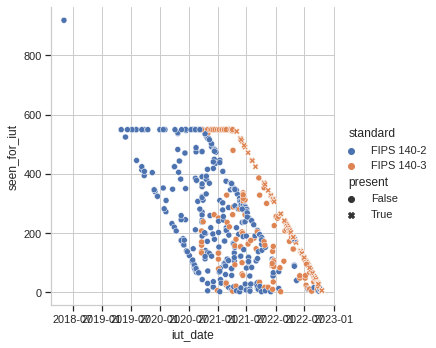

In [24]:
scatter = sns.relplot(kind="scatter", data=iut_local_df, x="iut_date", y="seen_for_iut", hue="standard", style="present", aspect=1)

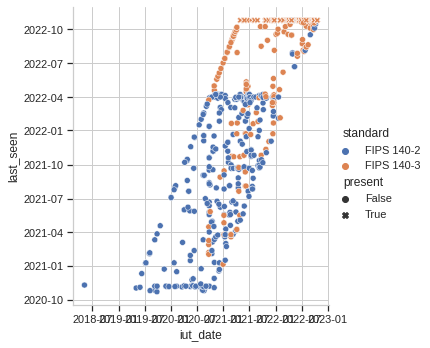

In [23]:
scatter = sns.relplot(kind="scatter", data=iut_local_df, x="iut_date", y="last_seen", hue="standard", style="present", aspect=1)

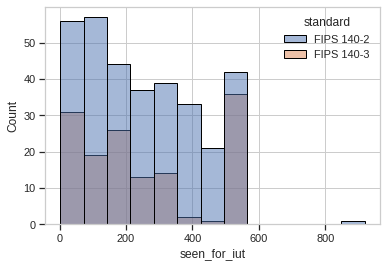

In [9]:
hist = sns.histplot(data=iut_local_df[~iut_local_df.present], x="seen_for_iut", hue="standard")

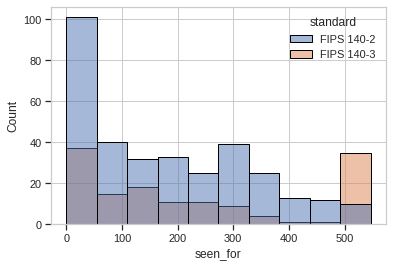

In [10]:
hist = sns.histplot(data=iut_local_df[~iut_local_df.present], x="seen_for", hue="standard")

In [11]:
iut_local_df.vendor.value_counts()

Cisco Systems, Inc.                   30
Fortinet, Inc.                        23
Juniper Networks, Inc.                22
Apple Inc.                            20
Oracle Corporation                    16
                                      ..
Microchip Technology Inc               1
L3Harris Technologies, Inc.            1
Brocade Communications Systems LLC     1
SafeLogic                              1
Nokia XHAUL                            1
Name: vendor, Length: 225, dtype: int64

## MIP dataset

In [12]:
mip_dset = MIPDataset.from_web_latest()

In [13]:
mip_global_df = pd.DataFrame(mip_dset.snapshots, columns=["timestamp", "displayed", "not_displayed", "total"])
mip_global_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727 entries, 0 to 726
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      727 non-null    datetime64[ns]
 1   displayed      727 non-null    int64         
 2   not_displayed  727 non-null    int64         
 3   total          727 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 22.8 KB


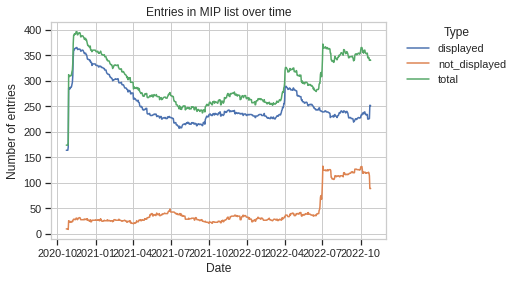

In [14]:
mip_melt = mip_global_df.melt("timestamp", var_name="type", value_name="count")
line = sns.lineplot(data=mip_melt, x="timestamp", y="count", hue="type")
line.set(xlabel="Date", ylabel="Number of entries", title="Entries in MIP list over time")
line.legend(title="Type", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [15]:
m0 = mip_dset.snapshots[0]
print(m0.__dict__.keys())
print(next(iter(m0.entries)))

dict_keys(['entries', 'timestamp', 'last_updated', 'displayed', 'not_displayed', 'total'])
MIPEntry(module_name='Dell BSAFE Crypto Module for C', vendor_name='Dell Australia Pty Limited, BSAFE Product Team', standard='FIPS 140-3', status=<MIPStatus.REVIEW_PENDING: 'Review Pending'>, status_since=datetime.date(2022, 10, 7))


In [16]:
def mip_key(entry):
    return entry.module_name, entry.vendor_name, entry.standard, entry.status

mip_first_seen = {}
mip_last_seen = {}
for snapshot in sorted(mip_dset.snapshots, key=lambda x: x.timestamp):
    snapshot_date = snapshot.timestamp.date()
    for entry in snapshot.entries:
        entry_key = entry # mip_key(entry) # or entry here
        if entry_key not in mip_first_seen:
            mip_first_seen[entry_key] = snapshot_date
        if entry_key not in mip_last_seen or mip_last_seen[entry_key] < snapshot_date:
            mip_last_seen[entry_key] = snapshot_date

#mip_local_df = pd.DataFrame([(entry[0], entry[1], entry[2], entry[3], mip_first_seen[entry], mip_last_seen[entry], mip_last_seen[entry] == snapshot_date) for entry in iut_first_seen.keys()], columns=("name", "vendor", "standard", "status", first_seen", "last_seen", "present"))
mip_local_df = pd.DataFrame([(entry.module_name, entry.vendor_name, entry.standard, entry.status, entry.status_since, mip_first_seen[entry], mip_last_seen[entry], mip_last_seen[entry] == snapshot_date) for entry in mip_first_seen.keys()], columns=("name", "vendor", "standard", "status", "status_since", "first_seen", "last_seen", "present"))
mip_local_df = mip_local_df.astype({"standard": "category", "status": "category", "status_since": "datetime64", "first_seen": "datetime64", "last_seen": "datetime64", "present": "bool"}).fillna(value=np.nan)
mip_local_df["seen_for_status"] = (mip_local_df.last_seen - mip_local_df.status_since).dt.days
mip_local_df["seen_for"] = (mip_local_df.last_seen - mip_local_df.first_seen).dt.days
mip_local_df.head()

,name,vendor,standard,status,status_since,first_seen,last_seen,present,seen_for_status,seen_for
0,Red Hat Enterprise Linux 7 NSS Cryptographic M...,"Red Hat(R), Inc.",FIPS 140-2,MIPStatus.IN_REVIEW,NaT,2020-10-22,2020-12-22,False,NaN,61
1,"FortiAP-U221EV, FortiAP-U223EV, FortiAP-U321EV...","Fortinet, Inc.",FIPS 140-2,MIPStatus.IN_REVIEW,NaT,2020-10-22,2021-04-28,False,NaN,188
2,"SBx908 GEN2, AT-x950-28XTQm, AT-x550-18XTQ, AT...",Allied Telesis,FIPS 140-2,MIPStatus.IN_REVIEW,NaT,2020-10-22,2020-10-27,False,NaN,5
3,"Juniper Networks MX240, MX480, MX960 3D Univer...","Juniper Networks, Inc.",FIPS 140-2,MIPStatus.IN_REVIEW,NaT,2020-10-22,2021-02-10,False,NaN,111
4,Cisco Network Convergence System 1001 Cryptogr...,"Cisco Systems, Inc.",FIPS 140-2,MIPStatus.COORDINATION,NaT,2020-10-22,2021-02-10,False,NaN,111


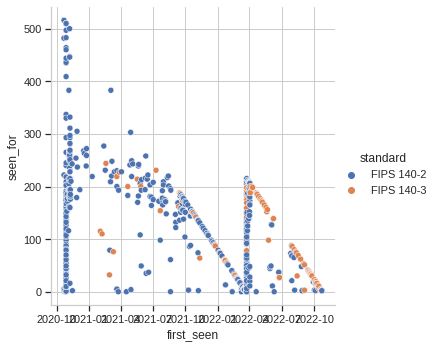

In [26]:
scatter = sns.relplot(kind="scatter", data=mip_local_df.loc[mip_local_df.status == MIPStatus.REVIEW_PENDING], x="first_seen", y="seen_for", hue="standard")

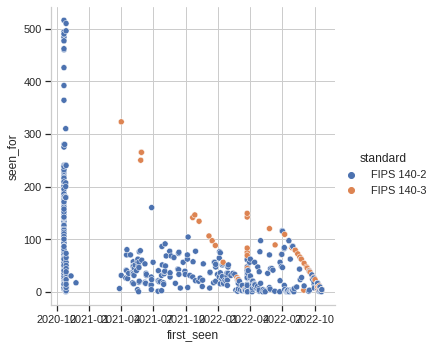

In [18]:
scatter = sns.relplot(kind="scatter", data=mip_local_df.loc[mip_local_df.status == MIPStatus.IN_REVIEW], x="first_seen", y="seen_for", hue="standard")

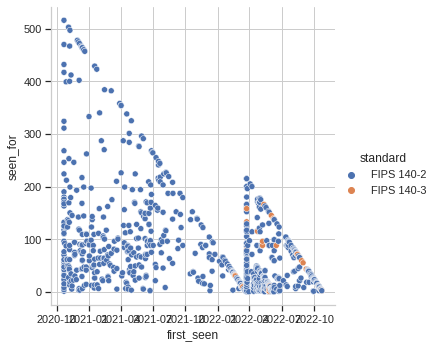

In [19]:
scatter = sns.relplot(kind="scatter", data=mip_local_df.loc[mip_local_df.status == MIPStatus.COORDINATION], x="first_seen", y="seen_for", hue="standard")

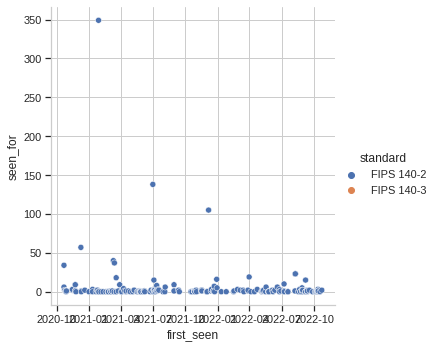

In [20]:
scatter = sns.relplot(kind="scatter", data=mip_local_df.loc[mip_local_df.status == MIPStatus.FINALIZATION], x="first_seen", y="seen_for", hue="standard")

In [21]:
for status in MIPStatus:
    print(status)
    print("All:")
    print("Average seen for", np.mean(mip_local_df.loc[mip_local_df.status == status].seen_for))
    print("Average seen for (FIPS 140-2)", np.mean(mip_local_df.loc[(mip_local_df.status == status) & (mip_local_df.standard == "FIPS 140-2")].seen_for))
    print("Average seen for (FIPS 140-3)", np.mean(mip_local_df.loc[(mip_local_df.status == status) & (mip_local_df.standard == "FIPS 140-3")].seen_for))
    
    print("Only not present:")
    print("Average seen for", np.mean(mip_local_df.loc[~(mip_local_df.present) & (mip_local_df.status == status)].seen_for))
    print("Average seen for (FIPS 140-2)", np.mean(mip_local_df.loc[~(mip_local_df.present) & (mip_local_df.status == status) & (mip_local_df.standard == "FIPS 140-2")].seen_for))
    print("Average seen for (FIPS 140-3)", np.mean(mip_local_df.loc[~(mip_local_df.present) & (mip_local_df.status == status) & (mip_local_df.standard == "FIPS 140-3")].seen_for))
    print()

MIPStatus.IN_REVIEW
All:
Average seen for 77.69056603773585
Average seen for (FIPS 140-2) 77.6923076923077
Average seen for (FIPS 140-3) 77.6734693877551
Only not present:
Average seen for 80.33265306122449
Average seen for (FIPS 140-2) 79.12608695652175
Average seen for (FIPS 140-3) 98.83333333333333

MIPStatus.REVIEW_PENDING
All:
Average seen for 118.98618090452261
Average seen for (FIPS 140-2) 121.27191679049034
Average seen for (FIPS 140-3) 106.47967479674797
Only not present:
Average seen for 122.6840579710145
Average seen for (FIPS 140-2) 123.05008077544427
Average seen for (FIPS 140-3) 119.49295774647888

MIPStatus.COORDINATION
All:
Average seen for 82.21221864951768
Average seen for (FIPS 140-2) 83.32062780269058
Average seen for (FIPS 140-3) 58.09756097560975
Only not present:
Average seen for 81.85060240963855
Average seen for (FIPS 140-2) 82.8583850931677
Average seen for (FIPS 140-3) 49.4

MIPStatus.FINALIZATION
All:
Average seen for 5.648780487804878
Average seen for (FIPS

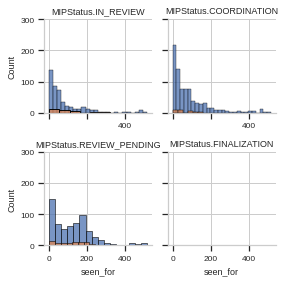

In [22]:
with sns.plotting_context("notebook", font_scale=0.75):
    g = sns.FacetGrid(mip_local_df.loc[~mip_local_df.present], col="status", hue="standard", col_wrap=2, height=2, ylim=(0,300))
    g.map(sns.histplot, "seen_for")
    g.set_titles("{col_name}")
    plt.show()